In [12]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn

from einops import rearrange, reduce, repeat

import itertools
from tqdm import tqdm


In [2]:
class ImageData():
    """
    Get image datasets as numpy arrays.
    """

    dataset_dict = {
        'mnist': torchvision.datasets.MNIST,
        'fmnist': torchvision.datasets.FashionMNIST,
        'cifar10': torchvision.datasets.CIFAR10,
        'cifar100': torchvision.datasets.CIFAR100,
        'svhn': torchvision.datasets.SVHN,
        'imagenet32': None,
        'imagenet64': None,
    }

    def __init__(self, dataset_name, data_dir, classes=None, onehot=True):
        """
        dataset_name (str): one of  'mnist', 'fmnist', 'cifar10', 'cifar100', 'imagenet32', 'imagenet64'
        dataset_dir (str): the directory where the raw dataset is saved
        classes (iterable): a list of groupings of old class labels that each constitute a new class.
            e.g. [[0,1], [8]] on MNIST would be a binary classification problem where the first class
            consists of samples of 0's and 1's and the second class has samples of 8's
        onehot (boolean): whether to use one-hot label encodings (typical for MSE loss). Default: True
        format (str): specify order of (sample, channel, height, width) dims. 'NCHW' default, or 'NHWC.'
            torchvision.dataset('cifar10') uses latter, needs ToTensor transform to reshape; former is ready-to-use.

        returns: numpy ndarray with shape (b, c, h, w)
        """

        assert dataset_name in self.dataset_dict
        self.name = dataset_name

        def format_data(dataset):
            if self.name in ['cifar10','cifar100']:
                X, y = dataset.data, dataset.targets
                X = rearrange(X, 'b h w c -> b c h w')
                y = np.array(y)
            if self.name in ['mnist', 'fmnist']:
                X, y = dataset.data.numpy(), dataset.targets.numpy()
                X = rearrange(X, 'b h w -> b 1 h w')
            if self.name in ['svhn']:
                X, y = dataset.data, dataset.labels
            if self.name in ['imagenet32', 'imagenet64']:
                X, y = dataset['data'], dataset['labels']
                X = rearrange(X, 'b d -> b c h w', c=3, h=32, w=32)
                y -= 1

            if classes is not None:
                # convert old class labels to new
                converter = -1 * np.ones(int(max(y)) + 1)
                for new_class, group in enumerate(classes):
                    group = [group] if type(group) == int else group
                    for old_class in group:
                        converter[old_class] = new_class
                # remove datapoints not in new classes
                mask = (converter[y] >= 0)
                X = X[mask]
                y = converter[y][mask]

            # make elements of input O(1)
            X = X/255.0
            # shape labels (N, nclasses)
            y = F.one_hot(torch.Tensor(y).long()).numpy() if onehot else y[:, None]

            return X.astype(np.float32), y.astype(np.float32)

        if self.name in ['cifar10','cifar100', 'mnist', 'fmnist']:
            raw_train = self.dataset_dict[self.name](root=data_dir, train=True, download=True)
            raw_test = self.dataset_dict[self.name](root=data_dir, train=False, download=True)
        if self.name == 'svhn':
            raw_train = self.dataset_dict[self.name](root=data_dir, split='train', download=True)
            raw_test = self.dataset_dict[self.name](root=data_dir, split='test', download=True)
        if self.name in ['imagenet32', 'imagenet64']:
            raw_train = np.load(f"{data_dir}/{self.name}-val.npz")
            raw_test = np.load(f"{data_dir}/{self.name}-val.npz")

        # process raw datasets
        self.train_X, self.train_y = format_data(raw_train)
        self.test_X, self.test_y = format_data(raw_test)

    def get_dataset(self, n, get="train", rng=None):
        """Generate an image dataset.

        n (int): the dataset size
        rng (numpy RNG): numpy RNG state for random sampling. Default: None
        get (str): either "train" or "test." Default: "train"

        Returns: tuple (X, y) such that X.shape = (n, *in_shape), y.shape = (n, *out_shape)
        """

        assert int(n) == n
        n = int(n)
        assert n > 0
        assert get in ["train", "test"]
        full_X, full_y = (self.train_X, self.train_y) if get == "train" else (self.test_X, self.test_y)

        # get subset
        idxs = slice(n) if rng is None else rng.choice(len(full_X), size=n, replace=False)
        X, y = full_X[idxs].copy(), full_y[idxs].copy()
        assert len(X) == n
        return X, y

In [3]:
class ExptTrace():

    @classmethod
    def multi_init(cls, num_init, var_names):
        return [cls(var_names) for _ in range(num_init)]

    def __init__(self, var_names):
        assert "val" not in var_names, f"variable name 'val' disallowed"
        self.var_names = var_names
        self.vals = {}
        self.valshape = None

    def __setitem__(self, key, val):
        if self.valshape is None:
            self.valshape = np.shape(val)
        assert np.shape(val) == self.valshape, f"value shape {np.shape(val)} != expected {self.valshape}"
        key = tuple((key,)) if not isinstance(key, tuple) else key
        assert len(key) == len(self.var_names), f"num keys {len(key)} != num vars {len(self.var_names)}"
        assert key not in self.vals, f"key {key} already exists. overwriting not supported"
        self.vals[key] = val

    def __getitem__(self, key):
        assert self.valshape is not None, "must add items before getting"
        key = tuple((key,)) if not isinstance(key, tuple) else key
        assert len(key) == len(self.var_names), f"num keys {len(key)} != num vars {len(self.var_names)}"
        key_axes = []
        for idx, var_name in enumerate(self.var_names):
            key_i = key[idx]
            key_idx_extent = [key_i]
            if isinstance(key_i, slice):
                slice_is_full = all([x==None for x in [key_i.start, key_i.stop, key_i.step]])
                assert slice_is_full, f"slice start/stop/step not supported ({var_name})"
                key_idx_extent = self.get_axis(var_name)
            key_axes.append(key_idx_extent)
        shape = [len(key_idx_extent) for key_idx_extent in key_axes]
        if np.prod(shape) == 1:
            assert key in self.vals, f"key {key} not found"
            return self.vals[key]
        vals = np.zeros(shape + list(self.valshape))

        idx_maps = []
        for axis in key_axes:
            idx_maps.append({val: i for i, val in enumerate(axis)})
        for key in itertools.product(*key_axes):
            shape_idxs = tuple(idx_maps[dim][val] for dim, val in enumerate(key))
            assert key in self.vals, f"key {key} not found"
            vals[shape_idxs] = self.vals[key]

        return vals

    def get_axis(self, var_name):
        assert var_name in self.var_names, f"var {var_name} not found"
        idx = self.var_names.index(var_name)
        key_idx_extent = set()
        for keys in self.vals.keys():
            key_idx_extent.add(keys[idx])
        return sorted(list(key_idx_extent))

    def get(self, **kwargs):
        key = self._get_key(_mode='get', **kwargs)
        return self[key]

    def set(self, **kwargs):
        assert "val" in kwargs, f"no val given"
        val = kwargs["val"]
        key = self._get_key(_mode='set', **kwargs)
        self[key] = val

    def is_written(self, **kwargs):
        key = self._get_key(_mode='set', **kwargs)
        return key in self.vals

    def _get_key(self, _mode='set', **kwargs):
        for var_name in self.var_names:
            if _mode == 'set':
                assert var_name in kwargs, f"must specify var {var_name}"
            elif _mode == 'get':
                if var_name not in kwargs:
                    kwargs[var_name] = slice(None, None, None)
            assert kwargs[var_name] is not None, f"var {var_name} cannot be None"
        key = tuple([kwargs[var_name] for var_name in self.var_names])
        return key

    def serialize(self):
        return {
            "var_names": self.var_names,
            "vals": self.vals,
            "valshape": self.valshape
        }

    @classmethod
    def deserialize(cls, data):
        obj = cls(data["var_names"])
        obj.vals = data["vals"]
        obj.valshape = data["valshape"]
        return obj


In [4]:
class ShallowReLU(nn.Module):

    def __init__(self, d_in=3072, d_out=10, width=3000, flstrength=1, leak=0):
        super().__init__()
        self.readin = nn.Linear(d_in, width, bias=False, dtype=torch.float64)
        self.readout = nn.Linear(width, d_out, bias=False, dtype=torch.float64)
        self.relu = nn.LeakyReLU(negative_slope=leak)

        self.flstrength = flstrength
        self.width = width
        self.d_in = d_in

        with torch.no_grad():
            sigma = 1 / (flstrength * np.sqrt(width))
            self.readin.weight.normal_(0, sigma)
            readin_norm = torch.linalg.norm(self.readin.weight, axis=1)
            self.readout.weight.normal_(0, 1).sign_().mul_(readin_norm*1e-2)

    def get_activations(self, x):
        h1 = np.sqrt(1 / self.d_in) * self.readin(x)
        h2 = np.sqrt(1 / self.width) * self.readout(self.relu(h1))
        return x, h1, h2

    def forward(self, x):
        _, _, h2 = self.get_activations(x)
        return h2

In [5]:
def test_error(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            d_out = output.shape[1]
            test_loss += F.mse_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1)
            correct += (pred==target.argmax(dim=1)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    return test_loss, accuracy

In [6]:
def show_img(img, ax, shape=(), vextent=None, cmap='gray'):
    if type(img) == torch.Tensor:
        img = img.cpu().numpy()
    if len(shape) == 2:
        h, w = shape
        img = rearrange(img, '(h w) -> h w 1', h=h, w=w)
    elif len(shape) == 3:
        cmap = None
        c, h, w = shape
        img = rearrange(img, '(c h w) -> h w c', h=h, w=w, c=c)
    else:
        assert img.ndim in [2, 3]
        if img.ndim == 3:
            cmap = None
    if vextent is None:
        img = (img - img.min()) / (img.max() - img.min())
        vextent = (0, 1)
    vmin, vmax = vextent
    ax.axis('off')
    return ax.imshow(img, vmin=vmin, vmax=vmax, cmap=cmap)

In [7]:
def get_cifar10_dataset(n_train, n_test, data_dir = 'data_dir', **kwargs):
    classes = kwargs.get("classes", None)
    cifar10 = ImageData('cifar10', data_dir, classes=classes)
    X_train, y_train = cifar10.get_dataset(n_train, get="train")
    X_test, y_test = cifar10.get_dataset(n_test, get="test")
    X_train, y_train, X_test, y_test = [torch.Tensor(t).cuda() for t in (X_train, y_train, X_test, y_test)]

    X_train = rearrange(X_train, 'Ntrain c h w -> Ntrain (c h w)')
    X_test = rearrange(X_test, 'Ntest c h w -> Ntest (c h w)')

    if kwargs.get('grayscale', False):
        X_train = reduce(X_train, 'N (3 s) -> N s', 'mean')
        X_test = reduce(X_test, 'N (3 s) -> N s', 'mean')

    if kwargs.get('center', False):
        X_mean = reduce(X_train, 'N d -> d', 'mean')
        X_train -= X_mean
        X_test -= X_mean

    if kwargs.get('normalize', False):
        X_train /= torch.linalg.norm(X_train, axis=1, keepdims=True)
        X_test /= torch.linalg.norm(X_test, axis=1, keepdims=True)
        if kwargs.get('center', False):
            X_mean = reduce(X_train, 'N d -> d', 'mean')
            X_train -= X_mean
            X_test -= X_mean

    if kwargs.get('whiten', False):
        assert not kwargs.get('normalize', False)

        X_mean = reduce(X_train, 'N d -> d', 'mean')
        X_train -= X_mean
        covar = torch.cov(X_train.T)
        U, S, _ = torch.linalg.svd(covar)
        zca_matrix = U @ torch.diag(1.0 / (torch.sqrt(S) + 1e-5))  @  U.T
        X_train = X_train @ zca_matrix
        X_test = X_test @ zca_matrix

    return X_train, y_train, X_test, y_test

In [8]:
# plt.rc("font", family='stixgeneral', size=14)
# plt.rc("mathtext", fontset='cm')

def style_axes(ax, numyticks=5, numxticks=5):
    ax.tick_params(axis="y", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True, direction='out', length=7, width=1.5, pad=8)#, labelsize=24)
    ax.tick_params(axis="x", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True, direction='out', length=7, width=1.5, pad=8)#, labelsize=24)
    # ax.xaxis.offsetText.set_fontsize(20)
    ax.grid(alpha=0.3)
    # Remove top/right borders and set linewidth
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    for spine in ["left", "bottom"]:
        ax.spines[spine].set_linewidth(1.5)


# Expt 4

100%|██████████| 170M/170M [00:24<00:00, 7.08MB/s] 


Extracting data_dir\cifar-10-python.tar.gz to data_dir
Files already downloaded and verified
E[norm(x)] = 0.9704
Optimal linear estimator MSE: 0.7551
tensor(5001.8739, device='cuda:0', dtype=torch.float64)


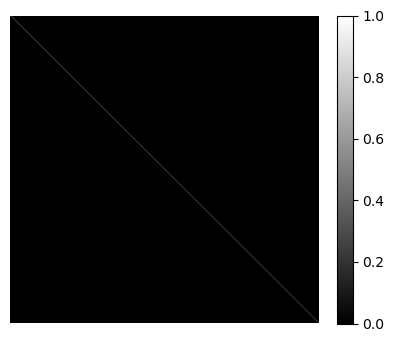

In [ ]:
classes = None
n_train = 10000
n_test = 2000
grayscale = True

DATA_DIR = None # <- put your dataset dir
X_train, y_train, X_test, y_test = get_cifar10_dataset(n_train, n_test, data_dir=DATA_DIR, classes=classes,
                                                       center=True, normalize=False, grayscale=grayscale)
startidx = 2000
X_train = X_train[startidx:startidx+5000]
y_train = y_train[startidx:startidx+5000]

U, S, Vt = torch.linalg.svd(X_train, full_matrices=False)
X_train = U @ Vt * np.sqrt(X_train.shape[0] / X_train.shape[1])
print(f'E[norm(x)] = {torch.linalg.norm(X_train, dim=-1).mean().item():.4f}')

X_train, y_train, X_test, y_test = [torch.Tensor(t).cuda().to(torch.float64) for t in (X_train, y_train, X_test, y_test)]

# Compute optimal linear mse
W = torch.linalg.lstsq(X_train, y_train).solution
d_in, d_out = X_train.shape[-1], y_train.shape[-1]
lin_mse = d_out * torch.mean((X_train @ W - y_train) ** 2).item()
print(f"Optimal linear estimator MSE: {lin_mse:.4f}")

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train),
                                           batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test),
                                          batch_size=2000, shuffle=False)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
C = X_train.T @ X_train
print(torch.trace(C))
im = show_img(C, ax)
plt.colorbar(im)

# fig, ax = plt.subplots(1, 1, figsize=(2, 2))
# shape = (32,32) if grayscale else (3,32,32)
# show_img(X_train[0], ax, shape=shape)

plt.show()

In [10]:
class ShallowMLP(nn.Module):

    def __init__(self, activ, d_in=3072, d_out=10, width=3000, init_scale=1):
        super().__init__()
        assert activ in ["linear", "relu", "tanh", "gelu", "elu"]
        self.readin = nn.Linear(d_in, width, bias=False, dtype=torch.float64)
        self.readout = nn.Linear(width, d_out, bias=False, dtype=torch.float64)
        self.dfac = 1
        if activ == "linear":
            self.activ = nn.Identity()
        elif activ == "relu":
            self.activ = nn.ReLU()
        elif activ == "tanh":
            self.activ = nn.Tanh()
        elif activ == "gelu":
            self.activ = nn.GELU()
            self.dfac *= 2
        elif activ == "elu":
            self.activ = nn.ELU()

        self.init_scale = init_scale
        self.width = width
        self.d_in = d_in

        with torch.no_grad():
            self.readin.weight.normal_(0, init_scale)
            self.readout.weight.normal_(0, init_scale)

    def get_activations(self, x):
        h1 = self.dfac * self.readin(x)
        h2 = (1 / self.width) * self.readout(self.activ(h1))
        return x, h1, h2

    def forward(self, x):
        _, _, h2 = self.get_activations(x)
        return h2


In [15]:
width = 128
init_scale = 1e-30
data_scale = 1
base_lr = 50
lr = base_lr / data_scale
activs = ["gelu", "linear"] # ["relu", "gelu", "elu", "tanh", "linear"]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(data_scale*X_train, y_train),
                                           batch_size=256, shuffle=True)

ntrials = 1
nepochs = 400

et_train_loss = ExptTrace(["activ", "nstep"])
et_svs = ExptTrace(["activ", "nstep"])

d_in, d_out = X_train.shape[-1], y_train.shape[-1]
model_copy = ShallowMLP(activ="linear", d_in=d_in, d_out=d_out, width=width, init_scale=init_scale).cuda()
for activ in activs:
    model = ShallowMLP(activ=activ, d_in=d_in, d_out=d_out, width=width, init_scale=init_scale).cuda()
    model.load_state_dict(model_copy.state_dict())
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    nsteps = 0
    for epoch in tqdm(range(nepochs)):
        train_loss, accuracy = test_error(model, train_loader)
        et_train_loss[activ, nsteps] = train_loss
        SVs = torch.linalg.svdvals(model.readin.weight).detach().cpu().numpy()
        et_svs[activ, nsteps] = SVs
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = d_out * F.mse_loss(output, target)
            loss.backward()
            optimizer.step()
            nsteps += 1

100%|██████████| 400/400 [01:29<00:00,  4.47it/s]


linear 74.71387627618134 1.553134244192916e-14
gelu 93.05943289144643 0.06331731773110123


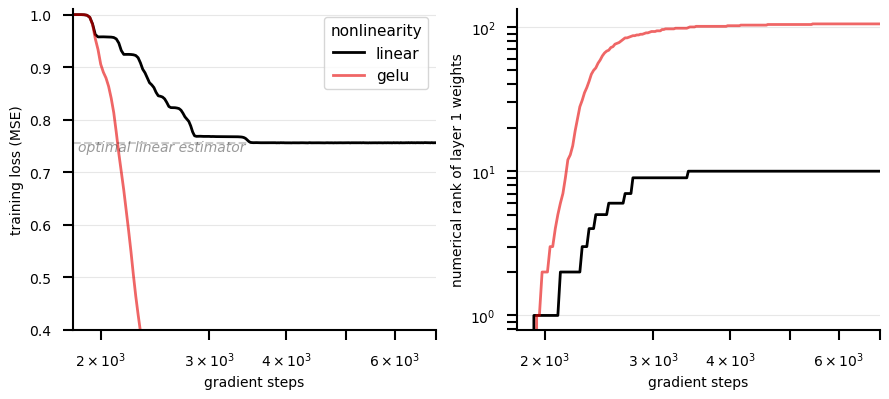

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4.1))
tscale = 'log'
xlim = (1800, 7000)
colors = ["xkcd:black", "xkcd:red", "xkcd:gold", "xkcd:green", "xkcd:azure"]

for i, activ in enumerate(activs[::-1]):
    if i!=0 and i!=4:
        kwargs = {"lw":2, "alpha":0.6}
    else:
        kwargs = {"lw":2}
    train_loss = et_train_loss[activ, :].squeeze()
    t = et_train_loss.get_axis('nstep')
    axes[0].plot(t, train_loss, label=f'{activ}', color=colors[i], **kwargs)


    S = et_svs[activ, :].squeeze()
    Smax = S.max(axis=-1)
    Smin = S.min(axis=-1)
    print(activ, Smax[-1], Smin[-1])
    eff_rank = np.sum(S>8e-2*Smax[-1], axis=-1)
    axes[1].plot(t, eff_rank, color=colors[i], **kwargs)

ax = axes[0]
ax.axhline(lin_mse, color='xkcd:black', alpha=0.2, ls='--')
ax.text(1.02*xlim[0], lin_mse-.014, "optimal linear estimator",
        color='xkcd:black', alpha=0.4, fontsize=10, fontdict={"style":"italic"})
ax.set_xscale(tscale)
ax.set_xlim(xlim)
ax.set_ylim(0.40, 1.01)
ax.set_xlabel('gradient steps')
ax.set_ylabel('training loss (MSE)')

ax.legend(title=f'nonlinearity', fontsize=11, title_fontsize=11)
style_axes(ax)

ax = axes[1]
ax.set_xscale(tscale)
ax.set_xlim(xlim)
ax.set_yscale('log')
ax.set_xlabel('gradient steps')
ax.set_ylabel('numerical rank of layer 1 weights')
style_axes(ax)


plt.tight_layout()
plt.savefig('stair-slide-normaldata.pdf')
plt.show()


### AGF

In [22]:
class SubNetwork(nn.Module):
    
    def __init__(self, d_in, d_out, nonlin=nn.Identity):
        super().__init__()
        self.w = nn.Linear(d_in, 1, bias=False)
        self.a = nn.Linear(1, d_out, bias=False)
        self.nonlin = nonlin()
        self.active = False
        self.util_acc = 0
        
        self.normalize()
    
    def forward(self, x):
        return self.a(self.nonlin(self.w(x)))
    
    def normalize(self):
        sqnorm = torch.linalg.norm(self.w.weight)**2 + torch.linalg.norm(self.a.weight)**2
        with torch.no_grad():
            self.w.weight.div_(torch.sqrt(sqnorm))
            self.a.weight.div_(torch.sqrt(sqnorm))
    
    def utility_step(self, x, residual, learning_rate):
        f_i = self(x)
        util = torch.einsum('nd,nd->n',  f_i, residual).mean()
        self.util_acc += 2 * learning_rate * util.item()
        util.backward()
        with torch.no_grad():
            self.w.weight += learning_rate * self.w.weight.grad
            self.a.weight += learning_rate * self.a.weight.grad
            self.w.weight.grad.zero_()
            self.a.weight.grad.zero_()
            self.normalize()


class Network(nn.Module):
    
    def __init__(self, d_in, d_out, width=100, nonlin=nn.Identity):
        super().__init__()
        neurons = [SubNetwork(d_in, d_out, nonlin) for _ in range(width)]
        self.neurons = nn.ModuleList(neurons)
        self.set_mode("utilmax")
        
    def set_mode(self, mode):
        if mode not in ["utilmax", "costmin"]:
            raise ValueError("mode must be utilmax or costmin")
        self.mode = mode
        for neuron in self.neurons:
            grad_on = (mode=="utilmax") ^ neuron.active
            for param in neuron.parameters():
                param.requires_grad = grad_on
    
    def forward(self, x):
        if not np.any([n.active for n in self.neurons]):
            return 0
        else:
            outputs = torch.stack([neuron(x) for neuron in self.neurons if neuron.active], dim=0)
            # figure out what to do with constants
            return torch.sum(outputs, dim=0) / len(self.neurons)


def train_agf(X_train, Y_train, init_sz=1e-20, agf_steps=5, nonlin=nn.Identity, utilmax_lr=1, costmin_lr=1,
              grad_thresh=1e-4):
    c_a = np.log(1/init_sz)
    d_in, d_out = X_train.shape[-1], Y_train.shape[-1]
    net = Network(d_in, d_out, width=agf_steps, nonlin=nonlin).to(torch.float64)    
    X_train.requires_grad = False
    
    def update_results(results, t):
        results["t"].append(t)
        residual = (Y_train - net(X_train))
        residual = residual.detach()
        results["residuals"].append(residual)
        loss = d_out * (residual**2).mean().item()
        results["losses"].append(loss)
        results["models"].append(net.state_dict())
        
    results = {
        "t": [],
        "residuals": [],
        "losses": [],
        "models": [],
    }
    t = 0
    update_results(results, t)
    for _ in tqdm(range(agf_steps)):
        residual = 2*(Y_train - net(X_train))
        residual = residual.detach()
        iters = 0
        while net.mode == "utilmax":
            for n in net.neurons:
                if n.active:
                    continue
                n.utility_step(X_train, residual, utilmax_lr)
                if n.util_acc > c_a:
                    n.active = True
                    net.set_mode("costmin")
                    break
            iters += 1
        t += iters * utilmax_lr
            
        optimizer = torch.optim.SGD(net.parameters(), lr=costmin_lr, momentum=0.5)
        iters = 0
        while net.mode == "costmin":
            optimizer.zero_grad(set_to_none=False)
            residual = (Y_train - net(X_train))
            loss = d_out * (residual**2).mean()
            loss.backward()
            if iters > 1000:
                net.set_mode("utilmax")
            optimizer.step()
            iters += 1
        update_results(results, t)
    
    return results

lr = 50
results = {}
for activ in activs:
    if activ == "linear":
        nonlin = nn.Identity
    elif activ == "relu":
        nonlin = nn.ReLU
    elif activ == "tanh":
        nonlin = nn.Tanh
    elif activ == "gelu":
        nonlin = nn.GELU
    elif activ == "elu":
        nonlin = nn.ELU
    results[activ] = train_agf(X_train.cpu(), y_train.cpu(), init_scale, agf_steps=9, nonlin=nonlin,
                    utilmax_lr=lr, costmin_lr=lr, grad_thresh=6e-3)
    print(np.round(results[activ]["losses"], 5))

100%|██████████| 9/9 [03:23<00:00, 22.64s/it]


[1.      0.99963 0.9306  0.93029 0.86748 0.86727 0.81193 0.8117  0.76036
 0.76019 0.7086  0.70846 0.66373 0.6635  0.62284 0.6226  0.58851 0.58834
 0.54615]


100%|██████████| 9/9 [03:21<00:00, 22.38s/it]

[1.      0.99928 0.95696 0.95656 0.92346 0.92293 0.89513 0.89477 0.86834
 0.86792 0.84362 0.84352 0.82152 0.82144 0.80231 0.80196 0.78443 0.78398
 0.76656]


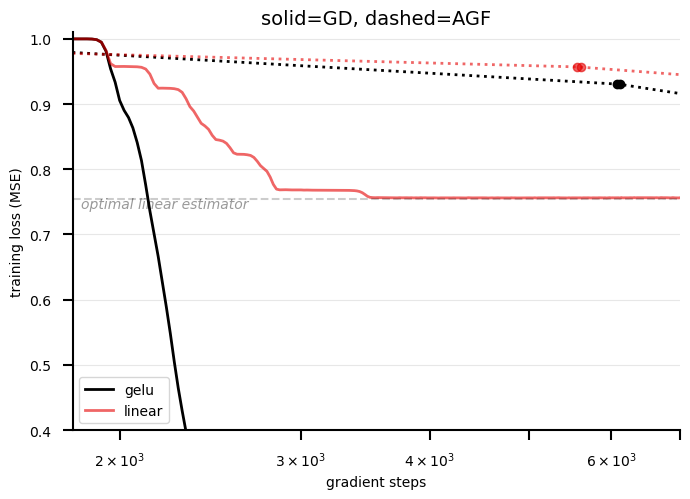

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5.1))
xlim = (1800, 7000)
colors = ["xkcd:black", "xkcd:red", "xkcd:gold", "xkcd:green", "xkcd:azure"]

for i, (activ, result) in enumerate(results.items()):
    if i!=0 and i!=4:
        kwargs = {"lw":2, "alpha":0.6}
    else:
        kwargs = {"lw":2}
    train_loss = et_train_loss[activ, :].squeeze()
    t = et_train_loss.get_axis('nstep')
    ax.plot(t, train_loss, label=f'{activ}', color=colors[i], **kwargs)
    
    ax.plot(.1*np.array(result["t"])+1, np.array(result["losses"]), color=colors[i], **kwargs, ls=":",
            marker='o')
    

ax.set_title("solid=GD, dashed=AGF", fontsize=14)
ax.axhline(lin_mse, color='xkcd:black', alpha=0.2, ls='--')
ax.text(1.02*xlim[0], lin_mse-.014, "optimal linear estimator",
        color='xkcd:black', alpha=0.4, fontsize=10, fontdict={"style":"italic"})
ax.set_xscale(tscale)
ax.set_xlim(xlim)
ax.set_ylim(0.40, 1.01)
ax.set_xlabel('gradient steps')
ax.set_ylabel('training loss (MSE)')
ax.legend()
style_axes(ax)


plt.tight_layout()
# plt.savefig('agf1.pdf')
plt.show()